Directorio de ROIs: /home/diego/Escritorio/AAL3/ROISignals_AAL3_NiftiPreprocessedAllBatchesNorm
Archivo CSV de metadatos: /home/diego/Escritorio/AAL3/SubjctsDataAndTests_Schaefer2018_400Parcels_17Networks.csv
Directorio de exportación: qc_outputs_doctoral_v2_aal3_aware
EXPECTED_ROIS (for analysis): 166
RAW_DATA_EXPECTED_COLUMNS (in .mat files): 170

--- Iniciando Bloque 1: Carga de Metadatos ---
Total de sujetos en CSV: 434
CSV con 434 sujetos detectado. ¡Correcto!
Sujetos con archivo .mat encontrado: 434
--- Bloque 1 Completado ---

--- Iniciando Bloque 3: QC Inicial por Sujeto ---

=== Estadísticas Descriptivas del QC Inicial (Raw Data) ===
                   count        mean           std         min         25%  \
TimePoints         434.0  176.981567  2.761145e+01  140.000000  140.000000   
ROIs_in_MatFile    434.0  170.000000  0.000000e+00  170.000000  170.000000   
NaNsCount          434.0  707.926267  1.104458e+02  560.000000  560.000000   
NaNsPct            434.0    2.352941 

/home/diego/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/diego/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/diego/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/diego/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert in

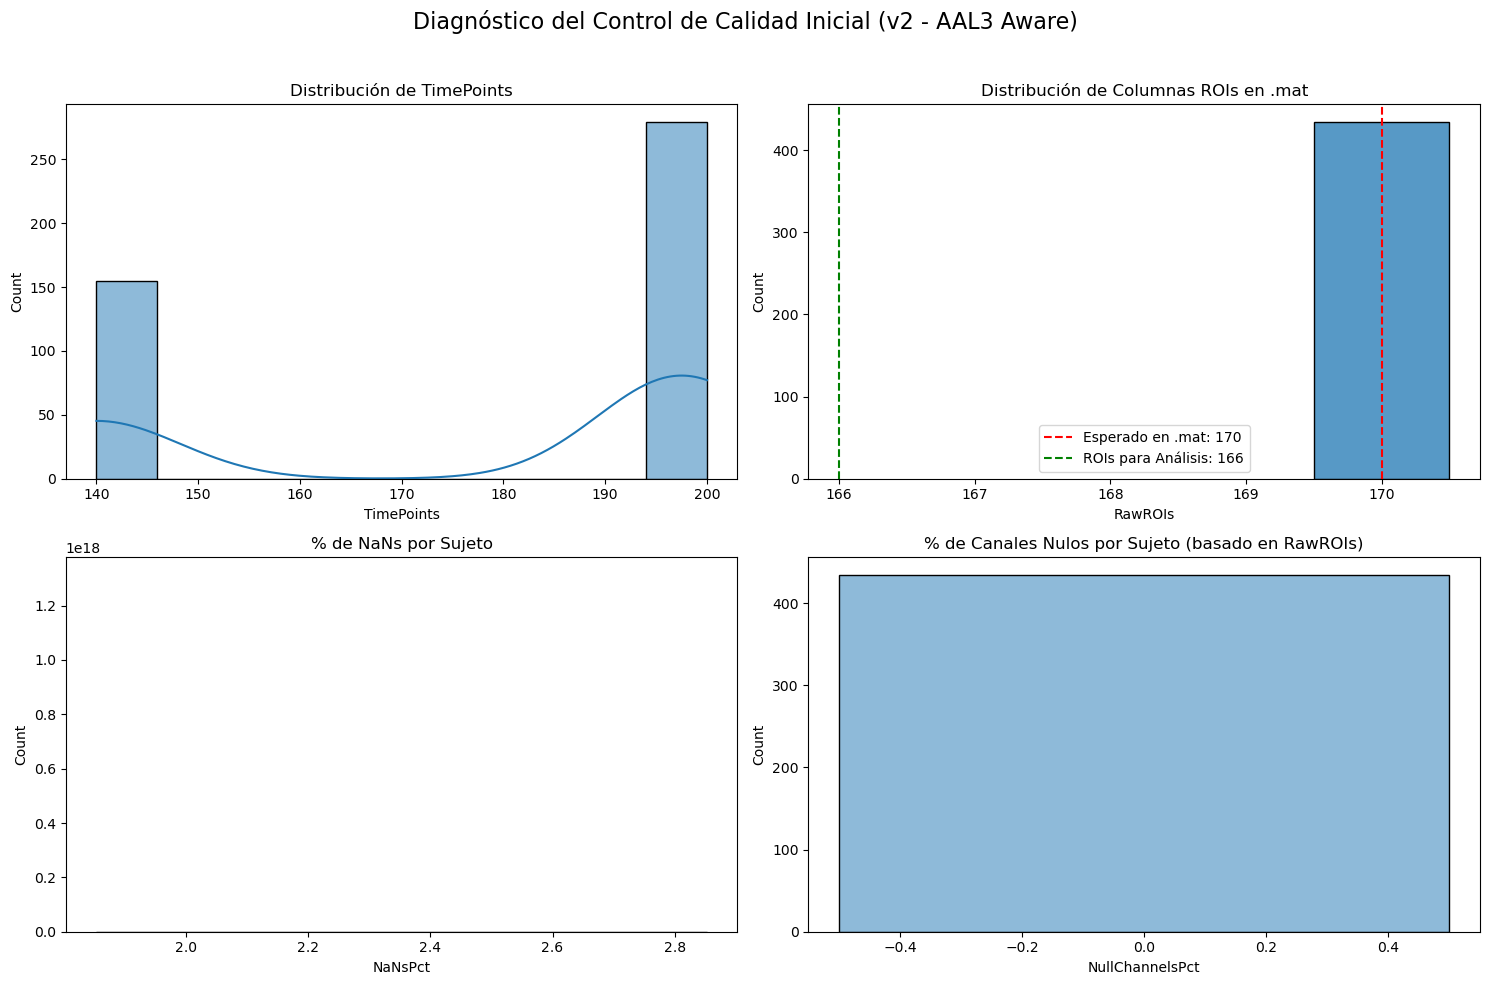


--- Revisión QC Inicial ---
Sujetos con número de columnas en .mat diferente a 170: 0
Sujetos con Canales Nulos (>0% en datos crudos): 0
¡Bien! Ningún sujeto tiene canales completamente nulos en los datos crudos (después de la limpieza manual).
--- Bloque 3 Completado ---

--- Iniciando Bloque 4: Detección de Outliers Univariantes (sobre datos crudos) ---

=== Estadísticas Descriptivas de Outliers Univariantes ===
                   count       mean        std       min        25%  \
UnivOutliersCount  434.0  49.834101  51.422132  1.000000  19.000000   
UnivOutliersPct    434.0   0.167764   0.160809  0.004303   0.067274   

                         50%       75%         max  
UnivOutliersCount  35.000000  63.00000  487.000000  
UnivOutliersPct     0.119259   0.20488    1.489206  


/home/diego/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


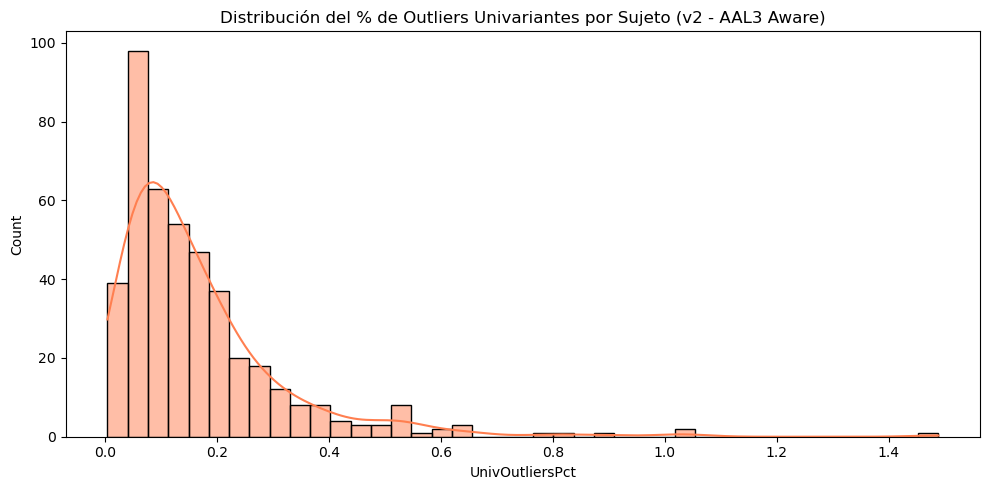

--- Bloque 4 Completado ---

--- Iniciando Bloque 5: Detección de Outliers Multivariantes (MCD) ---
Debug (Sujeto 002_S_0295): Shape INICIAL para MCD: (140, 170)
    Info (Sujeto 002_S_0295): Tiene 170 cols. Intentando remover 4 non-informative cols para llegar a 166.
    Info: Removidas 4 cols. Nuevo shape para MCD: (140, 166)
    Debug (Sujeto 002_S_0295): Shape FINAL para MCD (después de imputar): (140, 166)
    ADVERTENCIA (Sujeto 002_S_0295): Datos insuficientes para MCD (TPs: 140, ROIs procesados: 166). Omitiendo.
Debug (Sujeto 002_S_0413): Shape INICIAL para MCD: (140, 170)
    Info (Sujeto 002_S_0413): Tiene 170 cols. Intentando remover 4 non-informative cols para llegar a 166.
    Info: Removidas 4 cols. Nuevo shape para MCD: (140, 166)
    Debug (Sujeto 002_S_0413): Shape FINAL para MCD (después de imputar): (140, 166)
    ADVERTENCIA (Sujeto 002_S_0413): Datos insuficientes para MCD (TPs: 140, ROIs procesados: 166). Omitiendo.
Debug (Sujeto 002_S_0685): Shape INICIAL para MC

/home/diego/anaconda3/lib/python3.11/site-packages/sklearn/covariance/_robust_covariance.py:745: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


Debug (Sujeto 019_S_6573): Shape INICIAL para MCD: (197, 170)
    Info (Sujeto 019_S_6573): Tiene 170 cols. Intentando remover 4 non-informative cols para llegar a 166.
    Info: Removidas 4 cols. Nuevo shape para MCD: (197, 166)
    Debug (Sujeto 019_S_6573): Shape FINAL para MCD (después de imputar): (197, 166)
Debug (Sujeto 019_S_6585): Shape INICIAL para MCD: (197, 170)
    Info (Sujeto 019_S_6585): Tiene 170 cols. Intentando remover 4 non-informative cols para llegar a 166.
    Info: Removidas 4 cols. Nuevo shape para MCD: (197, 166)
    Debug (Sujeto 019_S_6585): Shape FINAL para MCD (después de imputar): (197, 166)
Debug (Sujeto 019_S_6630): Shape INICIAL para MCD: (197, 170)
    Info (Sujeto 019_S_6630): Tiene 170 cols. Intentando remover 4 non-informative cols para llegar a 166.
    Info: Removidas 4 cols. Nuevo shape para MCD: (197, 166)
    Debug (Sujeto 019_S_6630): Shape FINAL para MCD (después de imputar): (197, 166)
Debug (Sujeto 019_S_6635): Shape INICIAL para MCD: (197

/home/diego/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


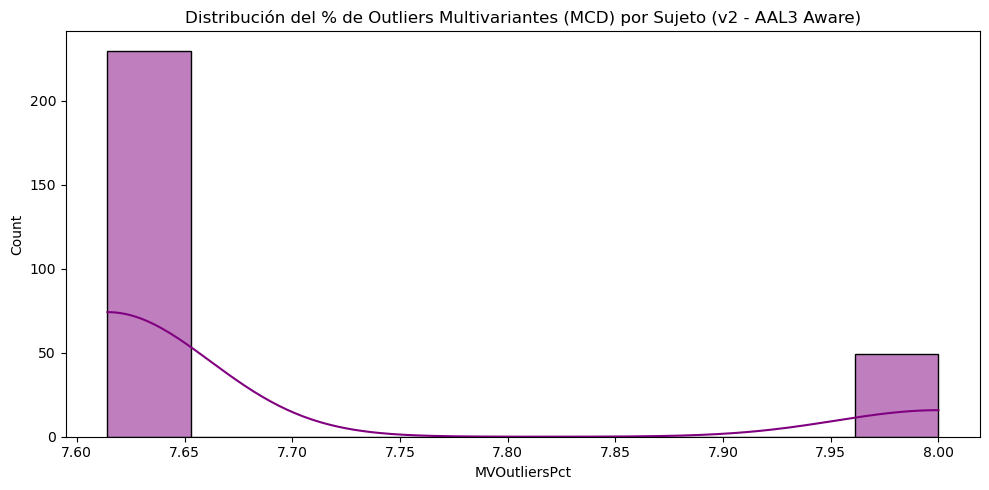

--- Bloque 5 Completado ---

--- Iniciando Bloque 6: Combinación de Métricas y Visualizaciones Globales ---


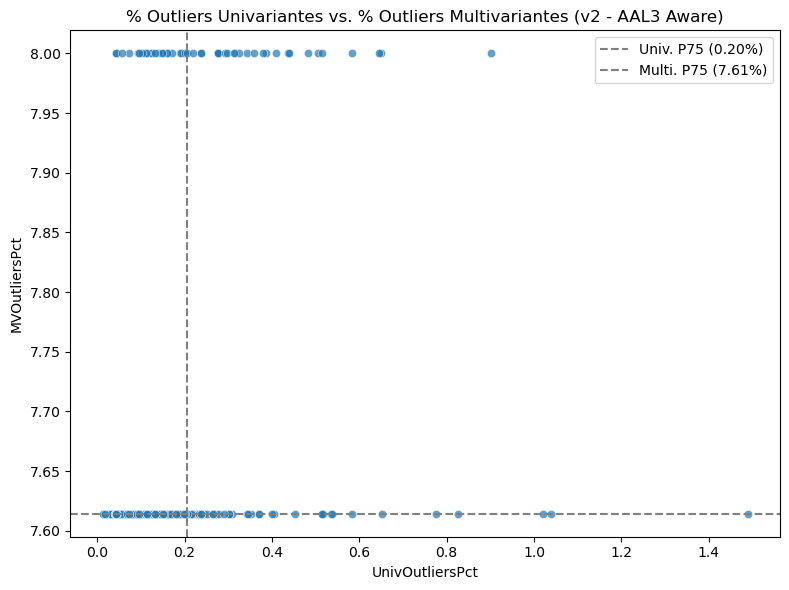

/home/diego/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/diego/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/diego/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


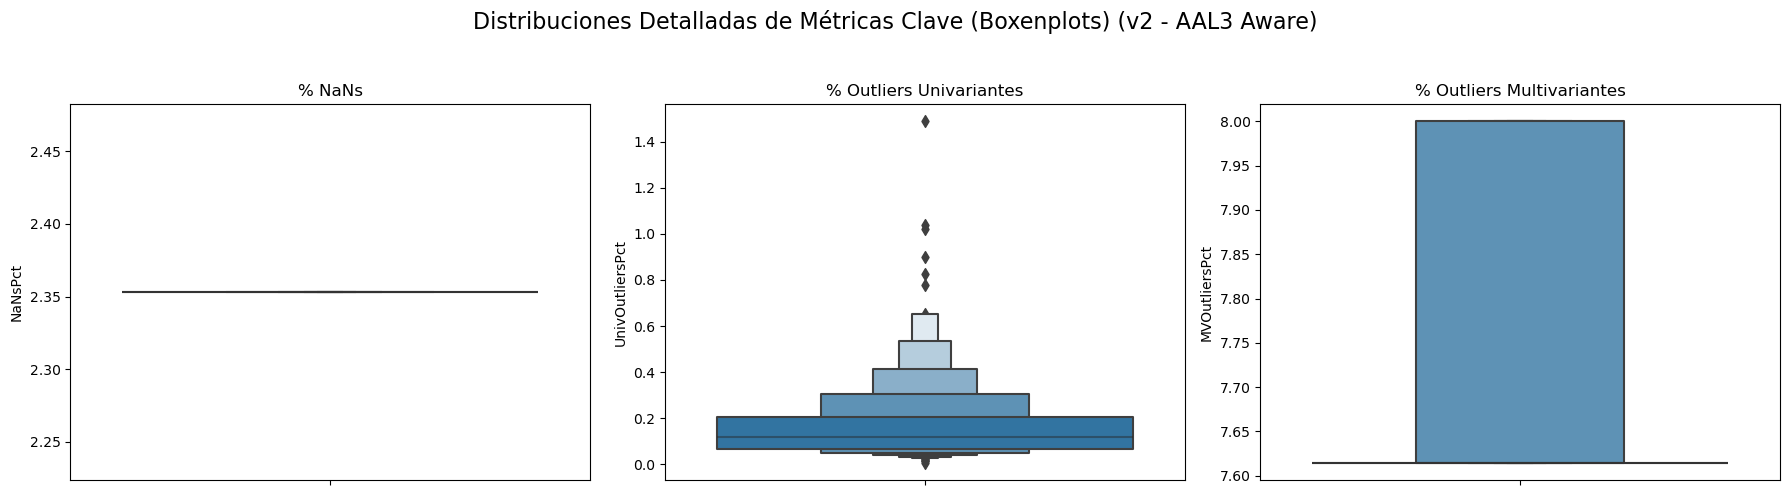


Generando Clustermap...


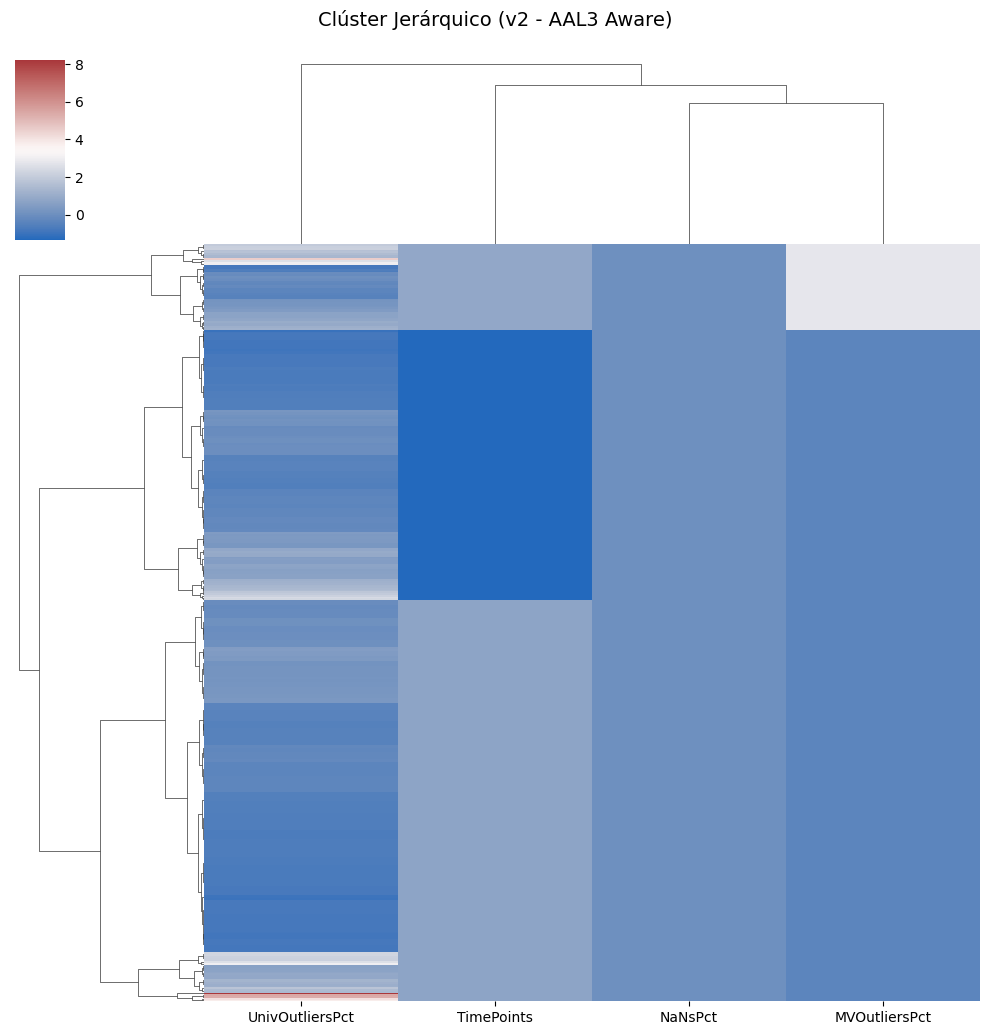


Reporte completo guardado en: qc_outputs_doctoral_v2_aal3_aware/report_qc_full_compiled_v2_aal3.csv
--- Bloque 6 Completado ---

--- Iniciando Bloque 7: Propuesta de Criterios de Exclusión (Refinado) ---

=== Umbrales de Exclusión Aplicados ===
TimePoints < 171.00
% Outliers Univariantes (IQR x1.5) > 0.411%
% Outliers Multivariantes (Media + 3.0*Std) > 8.123%
% NaNs (Absoluto) > 5.000%
% Canales Nulos en datos crudos (Absoluto) > 1.000%
Columnas ROIs en .mat != 170
Error en procesamiento de ROIs para MCD
Error en ejecución de MCD
Análisis MV omitido por TPs <= ROIs_procesados

=== Conteo de Sujetos por Criterio de Descarte ===
Sujetos por 'LowTP': 155
Sujetos por 'HighUniv': 28
Sujetos por 'HighMV': 0
Sujetos por 'HighNaNs': 0
Sujetos por 'HighNullRaw': 0
Sujetos por 'RawROIsNot170': 0
Sujetos por 'MCD_ROIProcessingIssue': 0
Sujetos por 'MCD_Error': 0
Sujetos por 'MCD_InsufficientData': 155

Total de sujetos propuestos para descartar (combinado): 177

Listas y reportes finales guardad

In [1]:
# ANÁLISIS DOCTORAL DE OUTLIERS EN SERIES BOLD (v2 - AAL3 Aware)
# -------------------------------------------------------------
# Refinamientos:
# - EXPECTED_ROIS set to 166 (true AAL3 parcellations).
# - RAW_DATA_EXPECTED_COLUMNS set to 170 (expected columns in .mat files).
# - Logic to identify and remove 4 non-informative columns before MCD.
# - Verification explícita del número de sujetos.
# - Manejo más claro de TPs < ROIs.
# - Umbral MV basado en std en lugar de IQR.
# - Visualizaciones adicionales (Boxenplot).
# - Criterios de exclusión ajustados.
# - Notas sobre rango de matriz y justificación.

import os
from pathlib import Path
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore, chi2
from sklearn.covariance import MinCovDet
from sklearn.impute import SimpleImputer
import warnings

# --- Ignorar UserWarnings de Scikit-learn (opcional, pero limpia el output) ---
# warnings.filterwarnings("ignore", category=UserWarning, module='sklearn.covariance._robust_covariance')

# ---------- CONFIGURACIÓN ----------
ROI_DIR = Path('/home/diego/Escritorio/AAL3/ROISignals_AAL3_NiftiPreprocessedAllBatchesNorm')
CSV_PATH = Path('/home/diego/Escritorio/AAL3/SubjctsDataAndTests_Schaefer2018_400Parcels_17Networks.csv')

EXPECTED_ROIS = 166  # True number of AAL3 parcellations to be analyzed
RAW_DATA_EXPECTED_COLUMNS = 170 # Expected columns in raw .mat files, including empty AAL3 labels

Z_THRESHOLD_UNIV = 3.5
ALPHA_MAHAL = 0.001
MIN_TIMEPOINTS_FOR_MV = 20 # Min TPs for MCD, independent of n_features > n_samples
EXPORT_DIR = Path('./qc_outputs_doctoral_v2_aal3_aware') # Nuevo directorio para v2

# Funciones auxiliares para calcular umbrales (deben definirse ANTES del Bloque 7)
def iqr_threshold_upper(series: pd.Series, multiplier: float = 1.5) -> float:
    if series.empty or series.isna().all():
        return np.nan # o np.inf si prefieres que no se aplique umbral
    q1, q3 = series.quantile([0.25, 0.75])
    if pd.isna(q1) or pd.isna(q3): # Si no se pueden calcular cuantiles
        return np.nan
    iqr = q3 - q1
    return q3 + multiplier * iqr

def std_threshold_upper(series: pd.Series, multiplier: float = 3.0) -> float:
    if series.empty or series.isna().all():
        return np.nan # o np.inf
    mean_val = series.mean()
    std_val = series.std()
    if pd.isna(mean_val) or pd.isna(std_val):
        return np.nan
    return mean_val + multiplier * std_val

# --- Criterios de Exclusión (Ajusta estos umbrales según tu criterio experto) ---
# ...el resto del Bloque 7 comienza aquí...
# thr_low_tp = TP_THRESHOLD_VALUE
# thr_univ = iqr_threshold_upper(qc_full_df['UnivOutliersPct'].dropna(), UNIV_OUTLIER_MULTIPLIER)
# etc.

# Criterios de Exclusión (Ajustables)
TP_THRESHOLD_VALUE = 171 # Umbral ABSOLUTO. Se sugiere > EXPECTED_ROIS (166) para permitir MCD.
UNIV_OUTLIER_MULTIPLIER = 1.5 # Multiplicador IQR para outliers univariantes
MV_OUTLIER_STD_MULTIPLIER = 3.0 # Multiplicador STD para outliers multivariantes
NANS_PCT_ABSOLUTE_THRESHOLD = 5.0 # Umbral absoluto para % NaNs (ej. 5%)
NULL_CHANNELS_PCT_ABSOLUTE_THRESHOLD = 1.0 # Umbral absoluto para % Canales Nulos (ej. 1%)
EXCLUDE_IF_MCD_SKIPPED_INSUFFICIENT_DATA = True # ¿Excluir si MCD fue omitido por TPs <= ROIs_processed?

# Crear directorio de exportación
EXPORT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Directorio de ROIs: {ROI_DIR}")
print(f"Archivo CSV de metadatos: {CSV_PATH}")
print(f"Directorio de exportación: {EXPORT_DIR}")
print(f"EXPECTED_ROIS (for analysis): {EXPECTED_ROIS}")
print(f"RAW_DATA_EXPECTED_COLUMNS (in .mat files): {RAW_DATA_EXPECTED_COLUMNS}\n")

# ---------- 1. CARGA DE METADATOS Y RUTAS .mat ----------
print("--- Iniciando Bloque 1: Carga de Metadatos ---")
try:
    meta_df = pd.read_csv(CSV_PATH)
    SUBJECT_ID_COL = 'SubjectID' # Ajusta si es necesario
    meta_df[SUBJECT_ID_COL] = meta_df[SUBJECT_ID_COL].astype(str).str.strip()
    meta_df['MatPath'] = meta_df[SUBJECT_ID_COL].apply(lambda sid: ROI_DIR / f'ROISignals_{sid}.mat')
    meta_df['MatExists'] = meta_df['MatPath'].apply(lambda p: p.exists())
    subjects_with_mat = meta_df[meta_df['MatExists']].copy()
    subjects_without_mat = meta_df[~meta_df['MatExists']]

    print(f"Total de sujetos en CSV: {len(meta_df)}")
    if len(meta_df) == 434:
        print("CSV con 434 sujetos detectado. ¡Correcto!")
    else:
        print(f"ADVERTENCIA: Se esperaban 434 sujetos en el CSV, pero se encontraron {len(meta_df)}. Verifica tu archivo CSV.")

    print(f"Sujetos con archivo .mat encontrado: {len(subjects_with_mat)}")
    if len(subjects_without_mat) > 0:
        print(f"ADVERTENCIA: {len(subjects_without_mat)} sujetos no tienen archivo .mat:")
        print(subjects_without_mat[[SUBJECT_ID_COL, 'MatPath']])
    if len(subjects_with_mat) == 0:
        raise FileNotFoundError("No se encontraron archivos .mat.")
    print("--- Bloque 1 Completado ---\n")
except Exception as e:
    print(f"Error en Bloque 1: {e}")
    exit()

# ---------- 2. FUNCIÓN DE QC INICIAL ----------
def qc_initial_subject(mat_path: Path, subject_id: str, raw_expected_cols: int):
    try:
        data = sio.loadmat(str(mat_path))
        signals_key = 'signals'
        if signals_key not in data: # Basic fallback
            potential_keys = [k for k, v in data.items() if isinstance(v, np.ndarray) and v.ndim == 2]
            if not potential_keys: raise KeyError("No se encontró 'signals' u otra matriz 2D.")
            signals_key = potential_keys[0]
            print(f"Warning (Sujeto {subject_id}): 'signals' key not found, using '{signals_key}'.")
        signals_matrix = np.asarray(data[signals_key], dtype=float)
    except Exception as e: # Catch loading errors
        return {
            'Subject': subject_id, 'ErrorLoading': True, 'TimePoints': np.nan, 'RawROIs': np.nan,
            'RawROIsMatchExpected': False, 'NaNsCount': np.nan, 'NaNsPct': np.nan,
            'ZerosCount': np.nan, 'ZerosPct': np.nan, 'NullChannelsCount': np.nan,
            'NullChannelsPct': np.nan, 'SignalsMatrix': None, 'MatPath': mat_path.name
        }
    tp, raw_rois = signals_matrix.shape
    nan_count = np.isnan(signals_matrix).sum()
    nan_pct = 100 * nan_count / signals_matrix.size if signals_matrix.size > 0 else 0
    zero_count = np.sum(signals_matrix == 0)
    zero_pct = 100 * zero_count / signals_matrix.size if signals_matrix.size > 0 else 0
    
    # Null channels based on the raw matrix
    null_channels_count = np.sum(np.all(signals_matrix == 0, axis=0)) if raw_rois > 0 else np.nan
    null_channels_pct = 100 * null_channels_count / raw_rois if raw_rois > 0 else np.nan
    
    return {
        'Subject': subject_id, 'MatPath': mat_path.name, 'ErrorLoading': False,
        'TimePoints': tp, 'RawROIs': raw_rois, # Number of columns as read from file
        'RawROIsMatchExpected': raw_rois == raw_expected_cols, # Check against 170
        'NaNsCount': nan_count, 'NaNsPct': nan_pct,
        'ZerosCount': zero_count, 'ZerosPct': zero_pct, 'NullChannelsCount': null_channels_count,
        'NullChannelsPct': null_channels_pct, 'SignalsMatrix': signals_matrix
    }

# ---------- 3. LOOP DE QC INICIAL ----------
print("--- Iniciando Bloque 3: QC Inicial por Sujeto ---")
qc_initial_results = []
all_signals_matrices = {} # Store original matrices
for _, row in subjects_with_mat.iterrows():
    # Pass RAW_DATA_EXPECTED_COLUMNS for the check
    qc_result = qc_initial_subject(row['MatPath'], row[SUBJECT_ID_COL], RAW_DATA_EXPECTED_COLUMNS)
    qc_initial_results.append(qc_result)
    if qc_result['SignalsMatrix'] is not None:
        all_signals_matrices[row[SUBJECT_ID_COL]] = qc_result['SignalsMatrix']

qc_initial_df = pd.DataFrame(qc_initial_results)
qc_display_df = qc_initial_df.drop(columns=['SignalsMatrix'])
print("\n=== Estadísticas Descriptivas del QC Inicial (Raw Data) ===")
print(qc_display_df.rename(columns={'RawROIs': 'ROIs_in_MatFile', 'RawROIsMatchExpected': f'ROIs_in_MatFile_is_{RAW_DATA_EXPECTED_COLUMNS}'}).describe().T)
qc_display_df.to_csv(EXPORT_DIR / 'report_qc_initial_v2_aal3.csv', index=False)
print(f"\nReporte de QC inicial guardado en: {EXPORT_DIR / 'report_qc_initial_v2_aal3.csv'}")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Diagnóstico del Control de Calidad Inicial (v2 - AAL3 Aware)', fontsize=16)
sns.histplot(qc_display_df['TimePoints'], kde=True, ax=axes[0,0]).set_title('Distribución de TimePoints')
# Plot RawROIs
sns.histplot(qc_display_df['RawROIs'], kde=False, discrete=True, ax=axes[0,1]).set_title('Distribución de Columnas ROIs en .mat')
axes[0,1].axvline(RAW_DATA_EXPECTED_COLUMNS, color='r', linestyle='--', label=f'Esperado en .mat: {RAW_DATA_EXPECTED_COLUMNS}')
axes[0,1].axvline(EXPECTED_ROIS, color='g', linestyle='--', label=f'ROIs para Análisis: {EXPECTED_ROIS}')
axes[0,1].legend()
sns.histplot(qc_display_df['NaNsPct'], kde=True, ax=axes[1,0]).set_title('% de NaNs por Sujeto')
sns.histplot(qc_display_df['NullChannelsPct'], kde=True, ax=axes[1,1]).set_title('% de Canales Nulos por Sujeto (basado en RawROIs)')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(EXPORT_DIR / 'plot_qc_initial_summary_v2_aal3.png')
plt.show()

print("\n--- Revisión QC Inicial ---")
# Check if any subject does NOT have RAW_DATA_EXPECTED_COLUMNS (170)
subjects_unexpected_raw_rois = qc_display_df[qc_display_df['RawROIs'] != RAW_DATA_EXPECTED_COLUMNS]
print(f"Sujetos con número de columnas en .mat diferente a {RAW_DATA_EXPECTED_COLUMNS}: {len(subjects_unexpected_raw_rois)}")
if not subjects_unexpected_raw_rois.empty: print(subjects_unexpected_raw_rois[['Subject', 'RawROIs']])

subjects_high_null_channels = qc_display_df[qc_display_df['NullChannelsPct'] > 0] # Based on raw 170 columns
print(f"Sujetos con Canales Nulos (>0% en datos crudos): {len(subjects_high_null_channels)}")
if not subjects_high_null_channels.empty: print(subjects_high_null_channels[['Subject', 'NullChannelsPct']])
else: print("¡Bien! Ningún sujeto tiene canales completamente nulos en los datos crudos (después de la limpieza manual).")
print("--- Bloque 3 Completado ---\n")

valid_subjects_df = qc_initial_df[~qc_initial_df['ErrorLoading'] & qc_initial_df['SignalsMatrix'].notna()].copy()
valid_subject_ids = valid_subjects_df['Subject'].tolist()

# ---------- 4. DETECCIÓN DE OUTLIERS UNIVARIANTES ----------
# This uses the original signals_matrix (e.g., 170 ROIs) as Z-score is per-column.
print("--- Iniciando Bloque 4: Detección de Outliers Univariantes (sobre datos crudos) ---")
univariate_outlier_results = []
for subject_id in valid_subject_ids:
    signals_matrix = all_signals_matrices[subject_id] # Original matrix
    if signals_matrix.size == 0:
        univariate_outlier_results.append({'Subject': subject_id, 'UnivOutliersCount': np.nan, 'UnivOutliersPct': np.nan})
        continue
    z_scores = zscore(signals_matrix, axis=0, nan_policy='omit')
    outlier_mask = np.abs(z_scores) > Z_THRESHOLD_UNIV
    univ_outliers_count = np.nansum(outlier_mask)
    num_valid_points = signals_matrix.size - np.sum(np.isnan(signals_matrix))
    univ_outliers_pct = 100 * univ_outliers_count / num_valid_points if num_valid_points > 0 else np.nan
    univariate_outlier_results.append({'Subject': subject_id, 'UnivOutliersCount': univ_outliers_count, 'UnivOutliersPct': univ_outliers_pct})

univariate_outliers_df = pd.DataFrame(univariate_outlier_results)
# Merge with valid_subjects_df (which contains RawROIs etc.)
qc_processed_df = pd.merge(valid_subjects_df.drop(columns=['SignalsMatrix']), univariate_outliers_df, on='Subject', how='left')
print("\n=== Estadísticas Descriptivas de Outliers Univariantes ===")
print(qc_processed_df[['UnivOutliersCount', 'UnivOutliersPct']].describe().T)
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(qc_processed_df['UnivOutliersPct'].dropna(), kde=True, ax=ax, color='coral')
ax.set_title('Distribución del % de Outliers Univariantes por Sujeto (v2 - AAL3 Aware)')
plt.tight_layout(); plt.savefig(EXPORT_DIR / 'plot_univariate_outliers_pct_dist_v2_aal3.png'); plt.show()
print("--- Bloque 4 Completado ---\n")

# ---------- 5. DETECCIÓN DE OUTLIERS MULTIVARIANTES (MCD) ----------
print("--- Iniciando Bloque 5: Detección de Outliers Multivariantes (MCD) ---")
multivariate_outlier_results = []
imputer = SimpleImputer(strategy='median') # Imputer for NaNs

for subject_id in valid_subject_ids:
    signals_matrix_orig = all_signals_matrices[subject_id] # Original matrix, e.g. (TPs, 170)
    signals_matrix_for_mcd = signals_matrix_orig.copy() # Start with a copy
    processed_roi_count_for_mcd = signals_matrix_for_mcd.shape[1]
    roi_processing_status = "OK"

    print(f"Debug (Sujeto {subject_id}): Shape INICIAL para MCD: {signals_matrix_for_mcd.shape}")

    if signals_matrix_for_mcd.shape[1] == RAW_DATA_EXPECTED_COLUMNS: # e.g., 170
        num_cols_to_remove = RAW_DATA_EXPECTED_COLUMNS - EXPECTED_ROIS # e.g., 170 - 166 = 4
        if num_cols_to_remove > 0:
            print(f"    Info (Sujeto {subject_id}): Tiene {RAW_DATA_EXPECTED_COLUMNS} cols. Intentando remover {num_cols_to_remove} non-informative cols para llegar a {EXPECTED_ROIS}.")
            
            with warnings.catch_warnings(): # Suppress RuntimeWarning for all-NaN slices
                warnings.simplefilter("ignore", category=RuntimeWarning)
                col_variances = np.nanvar(signals_matrix_for_mcd, axis=0)
            
            # Columns that are all NaN OR have near-zero variance
            near_zero_variance_threshold = 1e-9 # Threshold for "zero" variance
            non_informative_cols_mask = (np.all(np.isnan(signals_matrix_for_mcd), axis=0)) | \
                                        (col_variances < near_zero_variance_threshold)
            
            indices_to_remove = np.where(non_informative_cols_mask)[0]
            
            if len(indices_to_remove) >= num_cols_to_remove:
                # If more non-informative columns are found than needed, remove the expected number.
                # This assumes the first N are the ones to target, could be refined if specific indices of empty labels were known.
                actual_indices_to_remove = indices_to_remove[:num_cols_to_remove]
                signals_matrix_for_mcd = np.delete(signals_matrix_for_mcd, actual_indices_to_remove, axis=1)
                processed_roi_count_for_mcd = signals_matrix_for_mcd.shape[1]
                print(f"    Info: Removidas {len(actual_indices_to_remove)} cols. Nuevo shape para MCD: {signals_matrix_for_mcd.shape}")
                if processed_roi_count_for_mcd != EXPECTED_ROIS:
                    print(f"    ADVERTENCIA (Sujeto {subject_id}): Tras remoción, ROI count es {processed_roi_count_for_mcd}, se esperaba {EXPECTED_ROIS}.")
                    roi_processing_status = "ROI_count_mismatch_after_removal"
            else:
                print(f"    ADVERTENCIA (Sujeto {subject_id}): Se encontraron solo {len(indices_to_remove)} non-informative cols, se necesitaban {num_cols_to_remove}. MCD procederá con {signals_matrix_for_mcd.shape[1]} cols.")
                roi_processing_status = "Insufficient_cols_removed"
                # processed_roi_count_for_mcd remains signals_matrix_for_mcd.shape[1] (e.g. 170)
    elif signals_matrix_for_mcd.shape[1] != EXPECTED_ROIS: # If not 170 and also not 166
         print(f"    ADVERTENCIA (Sujeto {subject_id}): Shape inicial para MCD es {signals_matrix_for_mcd.shape}, no es {RAW_DATA_EXPECTED_COLUMNS} ni {EXPECTED_ROIS}. MCD procederá con este shape.")
         roi_processing_status = "Unexpected_initial_ROI_count"
         # processed_roi_count_for_mcd is signals_matrix_for_mcd.shape[1]
    
    # Impute NaNs on the (potentially processed) matrix
    if np.isnan(signals_matrix_for_mcd).any():
        signals_matrix_imputed = imputer.fit_transform(signals_matrix_for_mcd)
    else:
        signals_matrix_imputed = signals_matrix_for_mcd.copy()
        
    print(f"    Debug (Sujeto {subject_id}): Shape FINAL para MCD (después de imputar): {signals_matrix_imputed.shape}")

    # Check for sufficient data for MCD
    # Condition: n_samples > n_features (TPs > processed_roi_count_for_mcd)
    if signals_matrix_imputed.shape[0] <= processed_roi_count_for_mcd or \
       signals_matrix_imputed.shape[0] < MIN_TIMEPOINTS_FOR_MV:
        print(f"    ADVERTENCIA (Sujeto {subject_id}): Datos insuficientes para MCD (TPs: {signals_matrix_imputed.shape[0]}, ROIs procesados: {processed_roi_count_for_mcd}). Omitiendo.")
        multivariate_outlier_results.append({'Subject': subject_id, 'MVOutliersCount': np.nan, 'MVOutliersPct': np.nan, 
                                             'MVAnalysisSkipped': 'Insufficient_data', 'ROIs_for_MCD': processed_roi_count_for_mcd, 'ROI_Processing_Status': roi_processing_status})
        continue
    
    if roi_processing_status != "OK" and roi_processing_status != "Insufficient_cols_removed": # If there was a more serious issue
        # e.g. ROI_count_mismatch_after_removal or Unexpected_initial_ROI_count
        # or if "Insufficient_cols_removed" resulted in != EXPECTED_ROIS and we want to be strict
        if signals_matrix_imputed.shape[1] != EXPECTED_ROIS and roi_processing_status == "Insufficient_cols_removed":
             print(f"    ADVERTENCIA (Sujeto {subject_id}): ROI processing resulted in {signals_matrix_imputed.shape[1]} ROIs, not {EXPECTED_ROIS}. Omitiendo MCD.")
             multivariate_outlier_results.append({'Subject': subject_id, 'MVOutliersCount': np.nan, 'MVOutliersPct': np.nan,
                                                 'MVAnalysisSkipped': 'ROI_processing_issue', 'ROIs_for_MCD': processed_roi_count_for_mcd, 'ROI_Processing_Status': roi_processing_status})
             continue


    try:
        mcd = MinCovDet(support_fraction=None, random_state=42).fit(signals_matrix_imputed)
        md2 = mcd.mahalanobis(signals_matrix_imputed)
        # Degrees of freedom for Chi2 is the number of features used in MCD
        p_values = 1 - chi2.cdf(md2, df=signals_matrix_imputed.shape[1]) 
        mv_outliers_count = np.sum(p_values < ALPHA_MAHAL)
        mv_outliers_pct = 100 * mv_outliers_count / signals_matrix_imputed.shape[0]
        multivariate_outlier_results.append({'Subject': subject_id, 'MVOutliersCount': mv_outliers_count, 
                                             'MVOutliersPct': mv_outliers_pct, 'MVAnalysisSkipped': None,
                                             'ROIs_for_MCD': signals_matrix_imputed.shape[1], 'ROI_Processing_Status': roi_processing_status})
    except Exception as e:
        print(f"    ERROR en análisis multivariante para {subject_id}: {e}")
        multivariate_outlier_results.append({'Subject': subject_id, 'MVOutliersCount': np.nan, 'MVOutliersPct': np.nan, 
                                             'MVAnalysisSkipped': f'Error: {str(e)[:50]}', 
                                             'ROIs_for_MCD': signals_matrix_imputed.shape[1], 'ROI_Processing_Status': roi_processing_status})

multivariate_outliers_df = pd.DataFrame(multivariate_outlier_results)
qc_full_df = pd.merge(qc_processed_df, multivariate_outliers_df, on='Subject', how='left')

print("\n=== Estadísticas Descriptivas de Outliers Multivariantes ===")
print(qc_full_df[['MVOutliersCount', 'MVOutliersPct']].describe().T)
print("\nConteo de razones por las que se omitió el análisis MV:")
print(qc_full_df['MVAnalysisSkipped'].value_counts(dropna=False))
print("\nConteo de ROIs usados para MCD (para los que se intentó):")
print(qc_full_df['ROIs_for_MCD'].value_counts(dropna=False))
print("\nConteo de Status de Procesamiento de ROIs:")
print(qc_full_df['ROI_Processing_Status'].value_counts(dropna=False))


fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(qc_full_df['MVOutliersPct'].dropna(), kde=True, ax=ax, color='purple')
ax.set_title('Distribución del % de Outliers Multivariantes (MCD) por Sujeto (v2 - AAL3 Aware)')
plt.tight_layout(); plt.savefig(EXPORT_DIR / 'plot_multivariate_outliers_pct_dist_v2_aal3.png'); plt.show()
print("--- Bloque 5 Completado ---\n")

# ---------- 6. COMBINACIÓN DE MÉTRICAS Y VISUALIZACIONES ----------
print("--- Iniciando Bloque 6: Combinación de Métricas y Visualizaciones Globales ---")
for col in ['UnivOutliersPct', 'MVOutliersPct', 'NaNsPct', 'ZerosPct', 'NullChannelsPct', 'ROIs_for_MCD']:
    if col in qc_full_df.columns: qc_full_df[col] = pd.to_numeric(qc_full_df[col], errors='coerce')

plt.figure(figsize=(8, 6))
plot_data = qc_full_df[['UnivOutliersPct', 'MVOutliersPct']].dropna()
sns.scatterplot(x='UnivOutliersPct', y='MVOutliersPct', data=plot_data, alpha=0.7)
if not plot_data.empty:
    univ_q75 = plot_data['UnivOutliersPct'].quantile(0.75)
    mv_q75 = plot_data['MVOutliersPct'].quantile(0.75)
    plt.axvline(univ_q75, color='gray', linestyle='--', label=f'Univ. P75 ({univ_q75:.2f}%)')
    plt.axhline(mv_q75, color='gray', linestyle='--', label=f'Multi. P75 ({mv_q75:.2f}%)')
plt.title('% Outliers Univariantes vs. % Outliers Multivariantes (v2 - AAL3 Aware)')
plt.legend(); plt.tight_layout(); plt.savefig(EXPORT_DIR / 'plot_scatter_univ_vs_mv_outliers_v2_aal3.png'); plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Distribuciones Detalladas de Métricas Clave (Boxenplots) (v2 - AAL3 Aware)', fontsize=16)
sns.boxenplot(y=qc_full_df['NaNsPct'].dropna(), ax=axes[0]).set_title('% NaNs')
sns.boxenplot(y=qc_full_df['UnivOutliersPct'].dropna(), ax=axes[1]).set_title('% Outliers Univariantes')
sns.boxenplot(y=qc_full_df['MVOutliersPct'].dropna(), ax=axes[2]).set_title('% Outliers Multivariantes')
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.savefig(EXPORT_DIR / 'plot_boxenplots_metrics_v2_aal3.png')
plt.show()

cluster_metrics = ['TimePoints', 'NaNsPct', 'NullChannelsPct', 'UnivOutliersPct', 'MVOutliersPct', 'ROIs_for_MCD']
available_metrics = [m for m in cluster_metrics if m in qc_full_df.columns and qc_full_df[m].notna().any()]
if len(available_metrics) > 1:
    df_for_cluster = qc_full_df[available_metrics].copy()
    for col in available_metrics: df_for_cluster[col] = df_for_cluster[col].fillna(df_for_cluster[col].median()) # Use median for filling for clustering
    df_for_cluster_norm = (df_for_cluster - df_for_cluster.mean()) / df_for_cluster.std()
    df_for_cluster_norm.dropna(how='all', inplace=True) # Drop rows that are all NaN after normalization (if std was 0)
    df_for_cluster_norm.dropna(axis=1, how='all', inplace=True) # Drop columns that are all NaN (if a metric was all same value)


    if not df_for_cluster_norm.empty and len(df_for_cluster_norm) > 1 and df_for_cluster_norm.shape[1] > 1:
        print("\nGenerando Clustermap...")
        yticklabels_subjects = qc_full_df.loc[df_for_cluster_norm.index, 'Subject']
        show_labels_ytick = len(yticklabels_subjects) <= 75 # Show if 75 or less
        
        # Determine if column labels should be shown
        show_labels_xtick = df_for_cluster_norm.shape[1] <= 10

        try:
            cluster_map = sns.clustermap(df_for_cluster_norm, method='ward', metric='euclidean', cmap='vlag',
                                       figsize=(max(10, df_for_cluster_norm.shape[1]*0.8), max(10, len(df_for_cluster_norm) * 0.08 if show_labels_ytick else 10)),
                                       yticklabels=show_labels_ytick, xticklabels=show_labels_xtick, standard_scale=None)
            cluster_map.fig.suptitle('Clúster Jerárquico (v2 - AAL3 Aware)', y=1.03, fontsize=14) # Adjust y for suptitle
            plt.savefig(EXPORT_DIR / 'plot_clustermap_qc_metrics_v2_aal3.png', bbox_inches='tight'); plt.show()
        except Exception as e_cluster: print(f"Error generando clustermap: {e_cluster}")
    else: print("No hay suficientes datos/varianza para generar el clustermap.")
else: print("No hay suficientes métricas disponibles para generar el clustermap.")


qc_full_df.to_csv(EXPORT_DIR / 'report_qc_full_compiled_v2_aal3.csv', index=False)
print(f"\nReporte completo guardado en: {EXPORT_DIR / 'report_qc_full_compiled_v2_aal3.csv'}")
print("--- Bloque 6 Completado ---\n")

# ---------- 7. DEFINICIÓN DE CRITERIOS DE EXCLUSIÓN (Refinado) ----------
print("--- Iniciando Bloque 7: Propuesta de Criterios de Exclusión (Refinado) ---")

thr_low_tp = TP_THRESHOLD_VALUE
thr_univ = iqr_threshold_upper(qc_full_df['UnivOutliersPct'].dropna(), UNIV_OUTLIER_MULTIPLIER)
thr_mv = std_threshold_upper(qc_full_df['MVOutliersPct'].dropna(), MV_OUTLIER_STD_MULTIPLIER)
thr_nans = NANS_PCT_ABSOLUTE_THRESHOLD
thr_null_channels_raw = NULL_CHANNELS_PCT_ABSOLUTE_THRESHOLD # Based on raw NullChannelsPct

# Aplicar criterios
qc_full_df['Discard_LowTP'] = qc_full_df['TimePoints'] < thr_low_tp
qc_full_df['Discard_HighUniv'] = qc_full_df['UnivOutliersPct'] > thr_univ
qc_full_df['Discard_HighMV'] = qc_full_df['MVOutliersPct'] > thr_mv
qc_full_df['Discard_HighNaNs'] = qc_full_df['NaNsPct'] > thr_nans
qc_full_df['Discard_HighNullRaw'] = qc_full_df['NullChannelsPct'] > thr_null_channels_raw # From initial QC
qc_full_df['Discard_RawROIsNot170'] = qc_full_df['RawROIs'] != RAW_DATA_EXPECTED_COLUMNS
qc_full_df['Discard_MCD_InsufficientData'] = qc_full_df['MVAnalysisSkipped'] == 'Insufficient_data'
qc_full_df['Discard_MCD_ROIProcessingIssue'] = qc_full_df['MVAnalysisSkipped'] == 'ROI_processing_issue'
qc_full_df['Discard_MCD_Error'] = qc_full_df['MVAnalysisSkipped'].str.startswith('Error', na=False)


critical_discard_conditions = [
    'Discard_LowTP', 'Discard_HighUniv', 'Discard_HighMV',
    'Discard_HighNaNs', 'Discard_HighNullRaw',
    'Discard_RawROIsNot170', # If raw .mat files don't have 170 cols
    'Discard_MCD_ROIProcessingIssue', # If couldn't reduce 170 to 166 properly
    'Discard_MCD_Error',
]
if EXCLUDE_IF_MCD_SKIPPED_INSUFFICIENT_DATA:
    critical_discard_conditions.append('Discard_MCD_InsufficientData')

existing_critical_conditions = [c for c in critical_discard_conditions if c in qc_full_df.columns]
qc_full_df['ToDiscard_Overall'] = qc_full_df[existing_critical_conditions].any(axis=1)

print("\n=== Umbrales de Exclusión Aplicados ===")
print(f"TimePoints < {thr_low_tp:.2f}")
print(f"% Outliers Univariantes (IQR x{UNIV_OUTLIER_MULTIPLIER}) > {thr_univ:.3f}%")
print(f"% Outliers Multivariantes (Media + {MV_OUTLIER_STD_MULTIPLIER}*Std) > {thr_mv:.3f}%")
print(f"% NaNs (Absoluto) > {thr_nans:.3f}%")
print(f"% Canales Nulos en datos crudos (Absoluto) > {thr_null_channels_raw:.3f}%")
print(f"Columnas ROIs en .mat != {RAW_DATA_EXPECTED_COLUMNS}")
print(f"Error en procesamiento de ROIs para MCD")
print(f"Error en ejecución de MCD")
if EXCLUDE_IF_MCD_SKIPPED_INSUFFICIENT_DATA: print(f"Análisis MV omitido por TPs <= ROIs_procesados")

print("\n=== Conteo de Sujetos por Criterio de Descarte ===")
for col_name in existing_critical_conditions:
    print(f"Sujetos por '{col_name.replace('Discard_', '')}': {qc_full_df[col_name].sum()}")

subjects_to_discard_overall = qc_full_df[qc_full_df['ToDiscard_Overall']]
print(f"\nTotal de sujetos propuestos para descartar (combinado): {len(subjects_to_discard_overall)}")

subjects_to_discard_df = pd.DataFrame({'Subject': subjects_to_discard_overall['Subject']})
subjects_to_discard_df.to_csv(EXPORT_DIR / 'list_subjects_to_discard_final_v2_aal3.csv', index=False)
qc_full_df.to_csv(EXPORT_DIR / 'report_qc_final_with_discard_flags_v2_aal3.csv', index=False)
print(f"\nListas y reportes finales guardados en: {EXPORT_DIR}")
print("--- Bloque 7 Completado ---\n")

# ---------- 8. NOTAS PARA LA DISCUSIÓN DOCTORAL ----------
print("--- Bloque 8: Puntos Clave para la Discusión Doctoral ---")
print("1.  **Justificación de la Muestra Final:**")
print(f"    - Empezamos con {len(meta_df)} sujetos (después de la limpieza manual inicial).")
print(f"    - Se propuso descartar {len(subjects_to_discard_overall)}, resultando en una muestra final de {len(qc_full_df) - len(subjects_to_discard_overall)}.") # qc_full_df has all loaded subjects
print("    - Justifica cada criterio de exclusión: ¿Por qué esos umbrales? ¿Basado en datos, literatura?")
print(f"    - Discute el impacto de `TP_THRESHOLD_VALUE = {TP_THRESHOLD_VALUE}` y `EXCLUDE_IF_MCD_SKIPPED_INSUFFICIENT_DATA = {EXCLUDE_IF_MCD_SKIPPED_INSUFFICIENT_DATA}`.")
print("    - Detalla el proceso de reducción de ROIs de 170 a 166 y su impacto.")
print("\n2.  **Manejo de NaNs y Canales Nulos:**")
print(f"    - Se observó un promedio de {qc_full_df['NaNsPct'].mean():.2f}% de NaNs en los datos crudos.")
print(f"    - El umbral de {thr_null_channels_raw:.2f}% para canales nulos en datos crudos llevó a X exclusiones (ver conteo).")
print("\n3.  **Outliers Uni vs. Multi:**")
print("    - Compara los perfiles. ¿La reducción a 166 ROIs cambió la distribución de outliers MV?")
print("\n4.  **Matriz de Covarianza 'Not Full Rank':**")
print("    - Si las advertencias persistieron (incluso con 166 ROIs), discute la colinealidad inherente.")
print("\n5.  **Robustez y Sensibilidad del Atlas AAL3 y Parámetros:**")
print("    - Menciona la advertencia de AAL3 sobre regiones pequeñas y remuestreo.")
print("    - ¿Cómo podrían afectar los resultados las elecciones de `ALPHA_MAHAL`, `Z_THRESHOLD_UNIV`?")
print("\n6.  **Inspección Visual Adicional:**")
print("    - Esencial para justificar decisiones sobre sujetos límite.")
print("--- Fin del Análisis ---")

# Limpiar memoria
del all_signals_matrices
